C:\Users\otsuka\anaconda3\envs\scraping\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Model assignment per cluster:
Cluster 0: ['gpt-1' 'gpt-2' 'gpt-3' 'gpt-5' 'gpt-6' 'gemini-4' 'nbLM-1' 'nbLM-2'
 'nbLM-3' 'nbLM-4' 'nbLM-5' 'nbLM-6' 'nbLM-7']
Cluster 1: ['gpt-4' 'gpt-7' 'gemini-2' 'gemini-3' 'gemini-5' 'gemini-6' 'o3-1' 'o3-2'
 'o3-3' 'o3-4' 'o3-5' 'o3-6' 'o3-7']
Cluster 2: ['gemini-1' 'gemini-7' 'sonnet-4']
Cluster 3: ['grok-1' 'grok-2' 'grok-3' 'grok-4' 'grok-5' 'grok-6' 'grok-7']
Cluster 4: ['sonnet-1' 'sonnet-2' 'sonnet-3' 'sonnet-5' 'sonnet-6' 'sonnet-7']


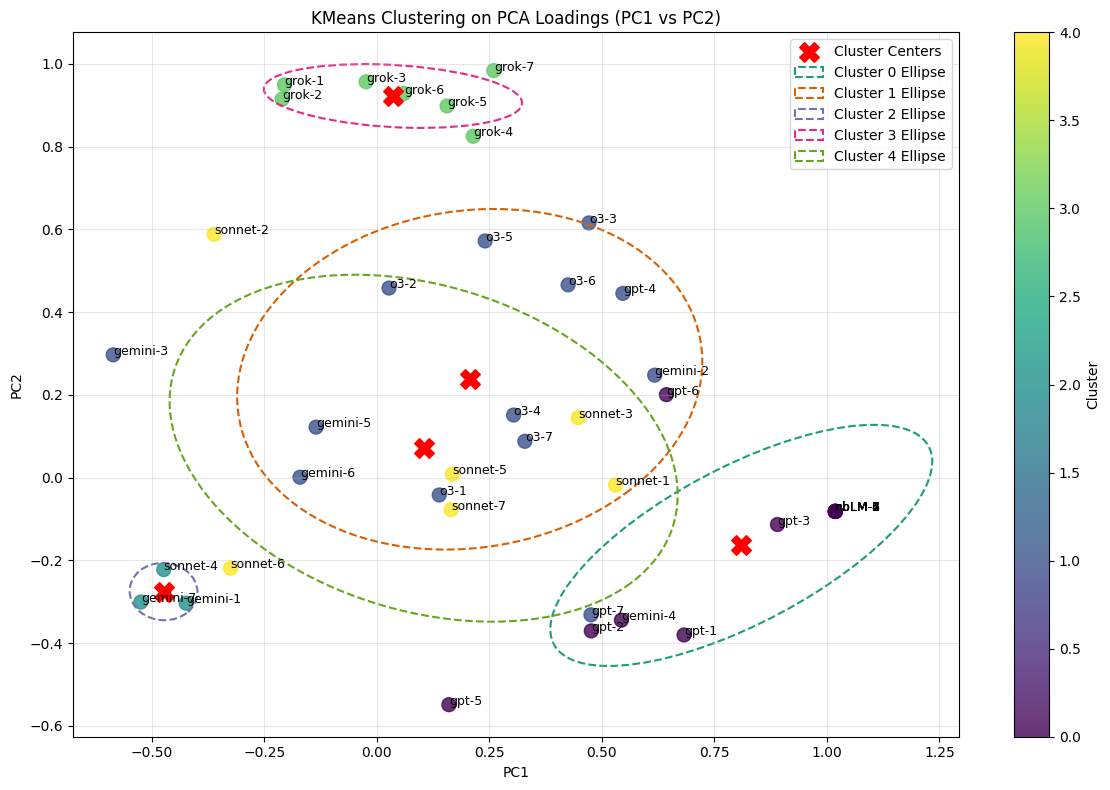

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Load CSV
df = pd.read_csv('official_row_data.csv', encoding='utf-8')

# Create pivot table: rows = stories, columns = model-session
df_cross = (
    df
    .set_index(['story', 'model', 'session'])['score']
    .unstack(['model', 'session'])
    .reset_index()
)

df_cross.columns = [
    col if isinstance(col, str) else f"{col[0]}-{col[1]}"
    for col in df_cross.columns
]

# Extract data matrix and feature names
story_titles = df_cross['story-'].values
X = df_cross.drop('story-', axis=1).values
feature_names = df_cross.columns[1:].tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
principal_components = pca.fit_transform(X_scaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Prepare loadings DataFrame
max_pcs = min(4, len(feature_names))
loadings_df = pd.DataFrame(
    loadings[:, :max_pcs],
    index=feature_names,
    columns=[f'PC{i+1}' for i in range(max_pcs)]
).reset_index().rename(columns={'index': 'feature'})

# Extract model names and assign short names
unique_models = loadings_df['feature'].str.rsplit('-', n=1).str[0].unique()

model_short_names = {}
for model in unique_models:
    if 'GPT' in model:
        model_short_names[model] = 'gpt'
    elif 'Gemini' in model:
        model_short_names[model] = 'gemini'
    elif 'Notebook' in model:
        model_short_names[model] = 'nbLM'
    elif 'Open' in model:
        model_short_names[model] = 'o3'
    elif 'Grok' in model:
        model_short_names[model] = 'grok'
    elif 'Sonnet' in model:
        model_short_names[model] = 'sonnet'
    else:
        model_short_names[model] = model

# Add abbreviated labels
loadings_df['label'] = loadings_df['feature'].apply(
    lambda x: model_short_names[x.rsplit('-', 1)[0]] + x[-2:]
)

# Prepare data for KMeans
X_cluster = loadings_df[['PC1', 'PC2', 'PC3', 'PC4']].values

# KMeans clustering (k=5)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
loadings_df['cluster'] = kmeans.fit_predict(X_cluster)
centers = kmeans.cluster_centers_

# Print cluster membership
print("\nModel assignment per cluster:")
for i in range(n_clusters):
    print(f"Cluster {i}: {loadings_df[loadings_df['cluster'] == i]['label'].values}")

# Confidence ellipse helper
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size != y.size or x.size <= 1:
        return None
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    transform = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(np.sqrt(cov[0, 0]) * n_std, np.sqrt(cov[1, 1]) * n_std) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transform + ax.transData)
    return ax.add_patch(ellipse)

# 2D visualization function
def visualize_clusters_2d(df, x_col, y_col, centers, n_clusters, colors, title, x_label, y_label):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df[x_col], df[y_col], c=df['cluster'], cmap='viridis', s=100, alpha=0.8, vmin=0, vmax=n_clusters - 1)

    if centers is not None and centers.shape[1] >= 2:
        x_idx = ['PC1', 'PC2', 'PC3', 'PC4'].index(x_col)
        y_idx = ['PC1', 'PC2', 'PC3', 'PC4'].index(y_col)
        plt.scatter(centers[:, x_idx], centers[:, y_idx], c='red', marker='X', s=200, label='Cluster Centers')

    for i, label in enumerate(df['label']):
        plt.annotate(label, (df[x_col][i], df[y_col][i]), fontsize=9)

    ax = plt.gca()
    for i in range(n_clusters):
        cluster_data = df[df['cluster'] == i]
        if len(cluster_data) >= 3:
            confidence_ellipse(
                cluster_data[x_col].values, 
                cluster_data[y_col].values,
                ax, n_std=1.5, edgecolor=colors[i], linestyle='--', linewidth=1.5,
                label=f'Cluster {i} Ellipse'
            )
        elif len(cluster_data) == 2:
            x = cluster_data[x_col].values
            y = cluster_data[y_col].values
            ax.plot(x, y, linestyle='--', color=colors[i], linewidth=1.5)

    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Color palette
colors = sns.color_palette('Dark2', n_colors=n_clusters)

# Visualize PC1 vs PC2
visualize_clusters_2d(
    loadings_df, 'PC1', 'PC2', centers, n_clusters, colors,
    'KMeans Clustering on PCA Loadings (PC1 vs PC2)',
    'PC1', 'PC2'
)
